# Task 2
## Prediction of m6A sites in all SG-NEx direct RNA-Seq samples 
<ul>
<li> Predict m6A RNA modifications in all samples from the SG-NEx data using our own method </li>
<li> Describe the results and compare them across the different cell lines </li>
<li> Summarise and visualise your observations </li>
</ul>

<b>Submission</b>: Describe the results and compare them across the different cell lines. Summarise and visualise your observations.

# Importing modules and functions

In [2]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns 
import joblib
import numpy as np
import torch
import torch.nn as nn
import sys
import os

from torch.utils.data import DataLoader, Dataset
from torch.utils.data.dataset import random_split

In [2]:
%run "../code/data_pre_process.py"

In [3]:
%run "../code/feature_eng_pipeline.py"

# Creating a Task 2 original merged dataset 
## Loading and processing the dataset 
## TO run when agg_task2_merged.csv not created.

In [4]:
# Takes about 5 minutes to load 
# A549 Lung cell line 
a549_rep5_df = pd.read_csv("../dataset/CSV/A549_replicate5_data.csv") # change input path accordingly 
a549_rep6_df = pd.read_csv("../dataset/CSV/A549_replicate6_data.csv")

# HCT116 Colon cell line
hct116_rep3_df = pd.read_csv("../dataset/CSV/HCT116_replicate3_data.csv")
hct116_rep3_run4_df = pd.read_csv("../dataset/CSV/HCT116_replicate3_run4_data.csv")
hct116_rep4_run3_df = pd.read_csv("../dataset/CSV/HCT116_replicate4_run3_data.csv")

# HepG2 Liver cell line
hepg2_rep5_df = pd.read_csv("../dataset/CSV/hepG2_replicate5_data.csv")
hepg2_rep6_df = pd.read_csv("../dataset/CSV/hepG2_replicate6_data.csv")

# K562 Leukocytes cell line
k562_rep4_df = pd.read_csv("../dataset/CSV/k562_replicate4_data.csv")
k562_rep5_df = pd.read_csv("../dataset/CSV/k562_replicate5_data.csv")
k562_rep6_df = pd.read_csv("../dataset/CSV/k562_replicate6_data.csv")

# MCF7 Breast cell line
mcf7_rep3_df = pd.read_csv("../dataset/CSV/mcf7_replicate3_data.csv")
mcf7_rep4_df = pd.read_csv("../dataset/CSV/mcf7_replicate4_data.csv")

# List of orig df 
orig_df_list = [a549_rep5_df, a549_rep6_df, hct116_rep3_df, hct116_rep3_run4_df, hct116_rep4_run3_df, hepg2_rep5_df,
                hepg2_rep6_df, k562_rep4_df, k562_rep5_df, k562_rep6_df, mcf7_rep3_df, mcf7_rep4_df ]

Aggregated dataset based on mean 

In [5]:
# A549 Lung cell line
a549_df = data_agg_mean(pd.concat([a549_rep5_df, a549_rep6_df], axis = 0))

# HCT116 Colon cell line
hct116_df = data_agg_mean(pd.concat([hct116_rep3_df, hct116_rep3_run4_df, hct116_rep4_run3_df], axis = 0))

# HepG2 Liver cell line
hepg2_df = data_agg_mean(pd.concat([hepg2_rep5_df, hepg2_rep6_df], axis = 0))

# K562 Leukocytes cell line
k562_df = data_agg_mean(pd.concat([k562_rep4_df, k562_rep5_df, k562_rep6_df], axis = 0))

# MCF7 Breast cell line
mcf7_df = data_agg_mean(pd.concat([mcf7_rep3_df, mcf7_rep4_df], axis = 0))

# List of agg df
agg_df_list = [a549_df, hct116_df, hepg2_df, k562_df, mcf7_df]

In [6]:
cell_line_name = ['A549', 'HCT116', 'HEPG2', 'K562', 'MCF7']
agg_df_list[0]["cell_line_name"] = cell_line_name[0]
agg_merged_df = agg_df_list[0]
for i in range(1, len(agg_df_list)):
    agg_df_list[i]["cell_line_name"] = cell_line_name[i]
    agg_merged_df = pd.concat([agg_merged_df, agg_df_list[i]], axis = 0)

agg_merged_df.to_csv("../dataset/agg_task2_merged.csv", index = False)

In [7]:
# Check
total_count = 0
for df in agg_df_list:
    total_count += len(df)
print(total_count)

assert total_count == len(agg_merged_df), "Please check the merge of raw data."

9733664


# Creating Task 2 predicted dataset
## TO run when pred_merged.csv not written

In [8]:
a549_pred_df= pd.read_csv("../code/prediction/ModNet_predict_on_a549.csv") # transcript_id | transcript_position | score
hct116_pred_df = pd.read_csv("../code/prediction/ModNet_predict_on_hct116.csv")
hepg2_pred_df = pd.read_csv("../code/prediction/ModNet_predict_on_hepg2.csv")
k562_pred_df = pd.read_csv("../code/prediction/ModNet_predict_on_k562.csv")
mcf7_pred_df = pd.read_csv("../code/prediction/ModNet_predict_on_mcf7.csv")

pred_list = [a549_pred_df, hct116_pred_df, hepg2_pred_df, k562_pred_df, mcf7_pred_df]

In [9]:
cell_line_name = ['A549', 'HCT116', 'HEPG2', 'K562', 'MCF7']
pred_list[0]["cell_line_name"] = cell_line_name[0]
pred_df = pred_list[0]
for i in range(1, len(agg_df_list)):
    pred_list[i]["cell_line_name"] = cell_line_name[i]
    pred_df = pd.concat([pred_df, pred_list[i]], axis = 0)

pred_df.to_csv("../dataset/pred_merged.csv", index = False)

In [10]:
# Check
total_count = 0
for df in pred_list:
    total_count += len(df)
print(total_count)

assert total_count == len(pred_df), "Please check the merge of raw data."

9733664


# Descriptive analytics 

In [3]:
agg_merged_df = pd.read_csv("../../dataset/agg_task2_merged.csv")
pred_df = pd.read_csv("../../dataset/pred_merged.csv")
print(f"Size of agg_merged_df: {len(agg_merged_df)}\nSize of pred_df: {len(pred_df)}")

Size of agg_merged_df: 9733664
Size of pred_df: 9733664


In [3]:
agg_merged_df.columns

Index(['transcript_name', 'json_position', 'nucleotide_seq',
       'dwelling_time_min1', 'sd_min1', 'mean_min1', 'dwelling_time', 'sd',
       'mean', 'dwelling_time_plus1', 'sd_plus1', 'mean_plus1',
       'dwelling_time_merged', 'sd_merged', 'mean_merged', 'cell_line_name'],
      dtype='object')

In [6]:
# obtaining the labels given a specific threshold 
pred_df['labels'] = pred_df['score'].apply(lambda x: 1 if x >= 0.99995 else 0)
pred_df.columns

Index(['transcript_id', 'transcript_position', 'score', 'cell_line_name',
       'labels'],
      dtype='object')

In [7]:
combined_df = pd.merge(agg_merged_df, pred_df, how = 'inner', left_on = ['transcript_name', 'json_position', 'cell_line_name'], right_on = ['transcript_id', 'transcript_position', 'cell_line_name'])
print(len(combined_df))

9733664


In [8]:
combined_df = combined_df.drop(['transcript_name', 'json_position'], axis = 1)
combined_df.columns

Index(['nucleotide_seq', 'dwelling_time_min1', 'sd_min1', 'mean_min1',
       'dwelling_time', 'sd', 'mean', 'dwelling_time_plus1', 'sd_plus1',
       'mean_plus1', 'dwelling_time_merged', 'sd_merged', 'mean_merged',
       'cell_line_name', 'transcript_id', 'transcript_position', 'score',
       'labels'],
      dtype='object')

In [9]:
m6a_sites_df = combined_df[['nucleotide_seq', 'cell_line_name', 'transcript_id', 'transcript_position', 'labels']]
m6a_sites_df.columns

Index(['nucleotide_seq', 'cell_line_name', 'transcript_id',
       'transcript_position', 'labels'],
      dtype='object')

### Bar graphs to show the number of unique methylated sites

In [10]:
m6a_expressed_df = m6a_sites_df[m6a_sites_df['labels'] == 1]
final_df = m6a_expressed_df.groupby(['nucleotide_seq', 'transcript_position'])['cell_line_name'].nunique().reset_index().rename(columns={'cell_line_name':'count_of_distinct_cell_line'})
# final_df = final_df.groupby("count_of_distinct_cell_line")["nucleotide_seq"].nunique().reset_index().rename(columns = {"nucleotide_seq":"count_of_distinct_nucleotide_seq"})
print(final_df)

# sns.barplot(data = final_df, x = 'count_of_distinct_cell_line', y = 'count_of_distinct_nucleotide_seq')
# plt.xlabel("Number of cell lines")
# plt.ylabel("Number of distinct nucleotide sequence")
# plt.title("Relationship between Cell Lines and Shared Nucleotide Sites")
# plt.show()

       nucleotide_seq  transcript_position  count_of_distinct_cell_line
0             AAAACAA                  687                            1
1             AAAACAA                  700                            1
2             AAAACAA                  991                            1
3             AAAACAA                 1073                            1
4             AAAACAA                 1226                            1
...               ...                  ...                          ...
124779        TTGACTT                 3739                            1
124780        TTGACTT                 4019                            1
124781        TTGACTT                 4191                            1
124782        TTGACTT                 4528                            1
124783        TTGACTT                 5098                            1

[124784 rows x 3 columns]


In [43]:
m6a_expressed_df = m6a_sites_df[m6a_sites_df['labels'] == 1]
def extract_substring(value):
    return value[1:6]

m6a_expressed_df["five_mers"] = m6a_expressed_df["nucleotide_seq"].apply(extract_substring)
print(m6a_expressed_df["five_mers"].unique())
final_df = m6a_expressed_df.groupby(['five_mers'])['cell_line_name'].nunique().reset_index().rename(columns={'cell_line_name':'count_of_distinct_cell_line'})
print(final_df)

['GGACT' 'GAACT' 'TGACA' 'AAACT' 'AAACC' 'GGACC' 'AGACT' 'TGACC' 'GGACA'
 'TGACT' 'AGACA' 'AAACA' 'GAACC' 'GAACA' 'AGACC' 'TAACT' 'TAACA']
   five_mers  count_of_distinct_cell_line
0      AAACA                            5
1      AAACC                            5
2      AAACT                            5
3      AGACA                            5
4      AGACC                            5
5      AGACT                            5
6      GAACA                            5
7      GAACC                            5
8      GAACT                            5
9      GGACA                            5
10     GGACC                            5
11     GGACT                            5
12     TAACA                            1
13     TAACT                            5
14     TGACA                            5
15     TGACC                            5
16     TGACT                            5


C:\Users\yilin\AppData\Local\Temp\ipykernel_3980\1069027305.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m6a_expressed_df["five_mers"] = m6a_expressed_df["nucleotide_seq"].apply(extract_substring)


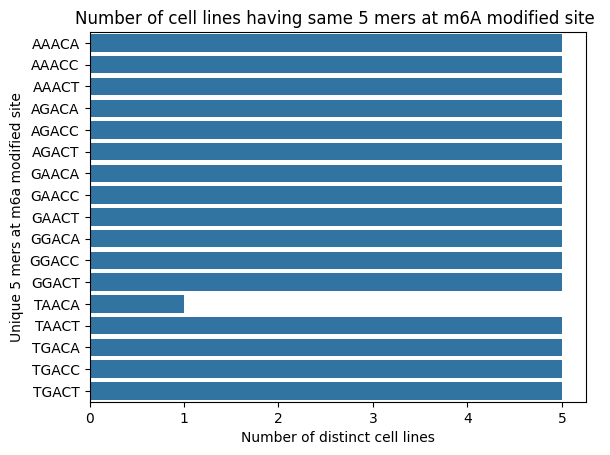

In [38]:
sns.barplot(data = final_df, x = 'count_of_distinct_cell_line', y = 'five_mers')
plt.xlabel("Number of distinct cell lines")
plt.ylabel("Unique 5 mers at m6a modified site")
plt.title("Number of cell lines having same 5 mers at m6A modified site ")
plt.show()

In [44]:
m6a_expressed_df[m6a_expressed_df["five_mers"]=="TAACA"]

,nucleotide_seq,cell_line_name,transcript_id,transcript_position,labels,five_mers
6135299,CTAACAA,K562,ENST00000356063,1326,1,TAACA


### Line graph to show the change in count of predicted label 1 against different threshold

In [22]:
pred_df = pd.read_csv("../dataset/pred_merged.csv")
thresholds = list(np.arange(0.99990, 1.00001, 0.00001))
thresholds_name_list = []
y = 9999
for i in thresholds:
    pred_df[f"{y}"] = pred_df['score'].apply(lambda x: 1 if x >= i else 0)
    thresholds_name_list.append(f"{y}")
    y += 1

melt_df = pred_df.melt(id_vars = ['cell_line_name'],
                       value_vars = thresholds_name_list,
                       var_name = "threshold")


In [ ]:
melt_df["threshold"] = melt_df["threshold"].astype(int)/10000
print(melt_df)

          cell_line_name  threshold  value
0                   A549    0.09999      0
1                   A549    0.09999      0
2                   A549    0.09999      0
3                   A549    0.09999      0
4                   A549    0.09999      0
...                  ...        ...    ...
116803963           MCF7    0.10010      0
116803964           MCF7    0.10010      0
116803965           MCF7    0.10010      0
116803966           MCF7    0.10010      0
116803967           MCF7    0.10010      0

[116803968 rows x 3 columns]


In [21]:
count_df = melt_df.groupby(['cell_line_name', 'threshold'])['value'].apply(lambda x: (x == 1).sum()).reset_index()
count_df = pd.merge(count_df, final_count, on = 'cell_line_name')
count_df['percentage'] = (count_df['value']/count_df['count']) * 100
print(count_df)

   cell_line_name  threshold  value    count  percentage
0            A549     0.9999  47513  1632577    2.910307
1            A549     1.0000  46856  1632577    2.870064
2            A549     1.0001  46172  1632577    2.828167
3            A549     1.0002  45368  1632577    2.778919
4            A549     1.0003  44495  1632577    2.725446
5            A549     1.0004  43363  1632577    2.656107
6            A549     1.0005  42093  1632577    2.578316
7            A549     1.0006  40407  1632577    2.475044
8            A549     1.0007  38147  1632577    2.336613
9            A549     1.0008  34420  1632577    2.108323
10           A549     1.0009  14819  1632577    0.907706
11           A549     1.0010      0  1632577    0.000000
12         HCT116     0.9999  69990  1963526    3.564506
13         HCT116     1.0000  69106  1963526    3.519485
14         HCT116     1.0001  68099  1963526    3.468200
15         HCT116     1.0002  66934  1963526    3.408868
16         HCT116     1.0003  6

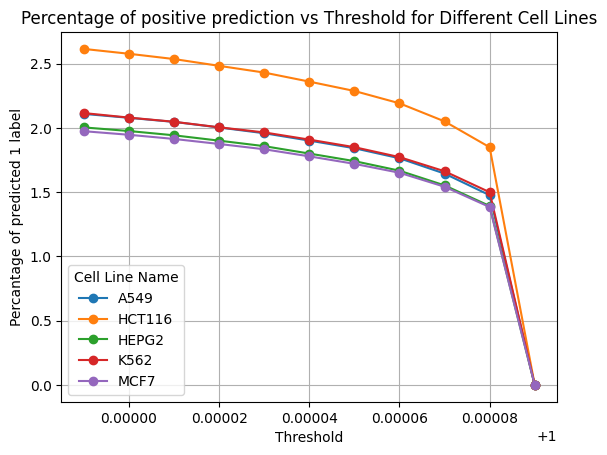

In [13]:
for cell_line in count_df['cell_line_name'].unique():
    subset = count_df[count_df['cell_line_name'] == cell_line]
    plt.plot(subset['threshold'], subset['percentage'], marker='o', label=cell_line)

# Adding labels and title
plt.xlabel('Threshold')
plt.ylabel('Percantage of predicted 1 label')
plt.title('Percentage of positive prediction vs Threshold for Different Cell Lines')
plt.legend(title='Cell Line Name')
plt.grid()

# Show the plot
plt.show()

In [ ]:
import pandas as pd
import numpy as np
pred_df = pd.read_csv("../dataset/pred_merged.csv")
thresholds = list(np.arange(0.99995, 1.000001, 0.000001))
thresholds_name_list = []
y = 90
for i in thresholds:
    pred_df[f"{y}"] = pred_df['score'].apply(lambda x: 1 if x >= i else 0)
    thresholds_name_list.append(f"{y}")
    y += 1

melt_df = pred_df.melt(id_vars = ['cell_line_name'],
                       value_vars = thresholds_name_list,
                       var_name = "threshold")

In [10]:
melt_df["threshold"] = melt_df["threshold"].astype(int)/100
print(melt_df)

          cell_line_name  threshold  value
0                   A549        0.9      0
1                   A549        0.9      0
2                   A549        0.9      0
3                   A549        0.9      0
4                   A549        0.9      0
...                  ...        ...    ...
107070299           MCF7        1.0      0
107070300           MCF7        1.0      0
107070301           MCF7        1.0      0
107070302           MCF7        1.0      0
107070303           MCF7        1.0      0

[107070304 rows x 3 columns]


In [11]:
count_df = melt_df.groupby(['cell_line_name', 'threshold'])['value'].apply(lambda x: (x == 1).sum()).reset_index()
print(count_df)

   cell_line_name  threshold   value
0            A549       0.90   99612
1            A549       0.91   98594
2            A549       0.92   97485
3            A549       0.93   96227
4            A549       0.94   94775
5            A549       0.95   93116
6            A549       0.96   91223
7            A549       0.97   88668
8            A549       0.98   85247
9            A549       0.99   79788
10           A549       1.00   14819
11         HCT116       0.90  142114
12         HCT116       0.91  140656
13         HCT116       0.92  139093
14         HCT116       0.93  137372
15         HCT116       0.94  135452
16         HCT116       0.95  133151
17         HCT116       0.96  130501
18         HCT116       0.97  127133
19         HCT116       0.98  122382
20         HCT116       0.99  114764
21         HCT116       1.00   22808
22          HEPG2       0.90  111630
23          HEPG2       0.91  110455
24          HEPG2       0.92  109188
25          HEPG2       0.93  107744
2

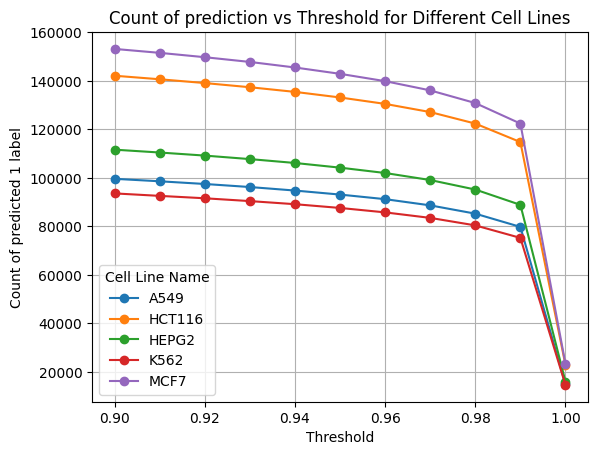

In [12]:
import matplotlib.pyplot as plt
for cell_line in count_df['cell_line_name'].unique():
    subset = count_df[count_df['cell_line_name'] == cell_line]
    plt.plot(subset['threshold'], subset['value'], marker='o', label=cell_line)

# Adding labels and title
plt.xlabel('Threshold')
plt.ylabel('Count of predicted 1 label')
plt.title('Count of prediction vs Threshold for Different Cell Lines')
plt.legend(title='Cell Line Name')
plt.grid()

# Show the plot
plt.show()

In [1]:
import pandas as pd
import numpy as np
pred_df = pd.read_csv("../dataset/pred_merged.csv")
thresholds = list(np.arange(0.99995, 1.000001, 0.000001))
thresholds_name_list = []
y = 999950
for i in thresholds:
    pred_df[f"{y}"] = pred_df['score'].apply(lambda x: 1 if x >= i else 0)
    thresholds_name_list.append(f"{y}")
    y += 1

melt_df = pred_df.melt(id_vars = ['cell_line_name'],
                       value_vars = thresholds_name_list,
                       var_name = "threshold")

In [2]:
melt_df["threshold"] = melt_df["threshold"].astype(int)/1000000
print(melt_df)

          cell_line_name  threshold  value
0                   A549    0.99995      0
1                   A549    0.99995      0
2                   A549    0.99995      0
3                   A549    0.99995      0
4                   A549    0.99995      0
...                  ...        ...    ...
496416859           MCF7    1.00000      0
496416860           MCF7    1.00000      0
496416861           MCF7    1.00000      0
496416862           MCF7    1.00000      0
496416863           MCF7    1.00000      0

[496416864 rows x 3 columns]


In [3]:
count_df = melt_df.groupby(['cell_line_name', 'threshold'])['value'].apply(lambda x: (x == 1).sum()).reset_index()
print(count_df)

MemoryError: Unable to allocate 3.70 GiB for an array with shape (496416864,) and data type int64

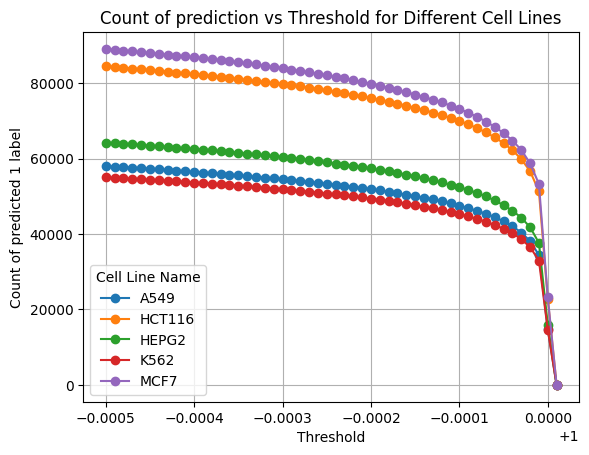

In [5]:
import matplotlib.pyplot as plt
for cell_line in count_df['cell_line_name'].unique():
    subset = count_df[count_df['cell_line_name'] == cell_line]
    plt.plot(subset['threshold'], subset['value'], marker='o', label=cell_line)

# Adding labels and title
plt.xlabel('Threshold')
plt.ylabel('Count of predicted 1 label')
plt.title('Count of prediction vs Threshold for Different Cell Lines')
plt.legend(title='Cell Line Name')
plt.grid()

# Show the plot
plt.show()


### Bar graphs to show the number of unique (transcripts, position) for each cell line

In [7]:
df = combined_df[['cell_line_name', 'transcript_id', 'transcript_position']].drop_duplicates()
final_count = df.groupby('cell_line_name').size().reset_index(name = "count")
print(final_count)

  cell_line_name    count
0           A549  1632577
1         HCT116  1963526
2          HEPG2  1879601
3           K562  1559321
4           MCF7  2698639


Text(0.5, 1.0, 'Number of unique transcript names at each cell line')

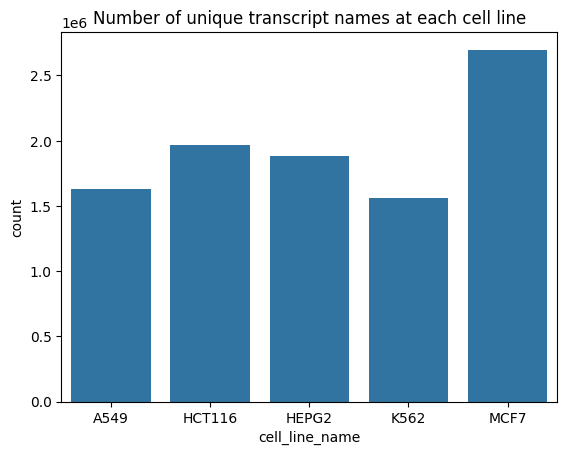

In [8]:
sns.barplot(data = final_count, x = 'cell_line_name', y = 'count')
plt.title("Number of unique transcript names at each cell line")

# Higher number of transcript counts in a cell line signifies greater complexity in a gene expression 

### Bar graphs to show the number of unique (5mers, position) at each cell line 

In [9]:
ns_df = combined_df[['cell_line_name', 'nucleotide_seq', 'transcript_position']].drop_duplicates()
ns_final_count = ns_df.groupby('cell_line_name').size().reset_index(name = "count")
print(ns_final_count)

  cell_line_name   count
0           A549  891555
1         HCT116  980007
2          HEPG2  960471
3           K562  851985
4           MCF7  920025


Text(0.5, 1.0, 'Number of unique 5-mers at each cell line')

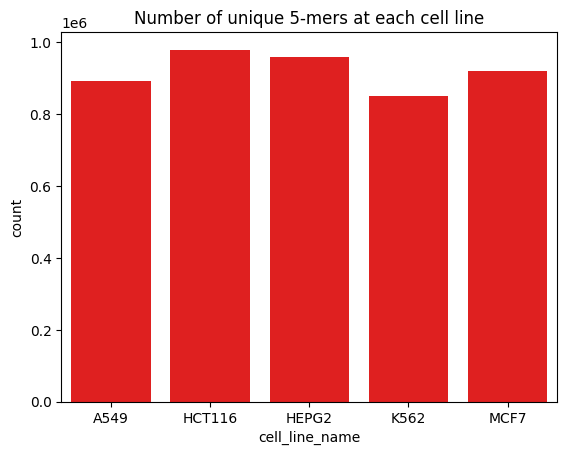

In [15]:
sns.barplot(data = ns_final_count, x = 'cell_line_name', y = 'count', color = "red")
plt.title("Number of unique 5-mers at each cell line")

### Finding the difference in dwelling time for the -1 position, 0 position and +1 position.

<Axes: xlabel='variable', ylabel='value'>

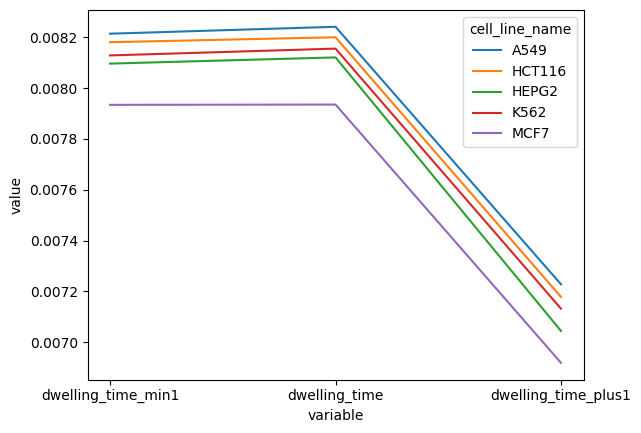

In [18]:
difference_df = combined_df 
difference_df = difference_df.groupby("cell_line_name")[["dwelling_time_min1", "dwelling_time", "dwelling_time_plus1"]].mean().reset_index()
difference_df = difference_df.melt(id_vars = "cell_line_name",
                                   value_vars = ["dwelling_time_min1", "dwelling_time", "dwelling_time_plus1"],
                                   )
sns.lineplot(data = difference_df, x = 'variable', y = 'value', hue = 'cell_line_name')

### Determining the percentage of predicted 0 and 1 labels in each cell line.

In [41]:
remove_dup_df = combined_df.drop_duplicates(keep=False)
final_df = remove_dup_df.groupby(['cell_line_name', 'labels'])['transcript_id'].nunique().reset_index()
total_count = final_df.groupby('cell_line_name')['transcript_id'].transform('sum')
final_df['percentage'] = (final_df['transcript_id']/total_count) * 100
print(final_df)

  cell_line_name  labels  transcript_id  percentage
0           A549       0          47066   68.557362
1           A549       1          21586   31.442638
2         HCT116       0          57083   67.137514
3         HCT116       1          27941   32.862486
4          HEPG2       0          52728   69.112500
5          HEPG2       1          23565   30.887500
6           K562       0          53171   70.572854
7           K562       1          22171   29.427146
8           MCF7       0          89755   70.776886
9           MCF7       1          37059   29.223114


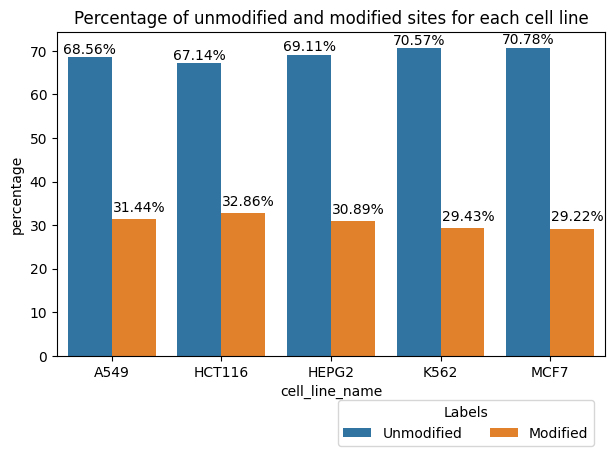

In [32]:
barplot = sns.barplot(data = final_df, x = 'cell_line_name', y = 'percentage', hue = 'labels')
for index, row in final_df.iterrows():
    # Adjust x and y positions as needed
    if index % 2 == 0:
        x_pos = index % 2  + (index // 2) -0.2 # Offset for bar position
        y_pos = row['percentage'] + 0.2 # Position slightly above the bar
        barplot.text(x_pos, y_pos, f"{round(row['percentage'], 2)}%", 
                    ha='center', va='bottom')
    else:
        x_pos = (index-0.75)% 2  + ((index -0.7)// 2)  # Offset for bar position
        y_pos = row['percentage'] + 1 # Position slightly above the bar
        barplot.text(x_pos, y_pos, f"{round(row['percentage'], 2)}%", 
                    ha='center', va='bottom')

new_labels = ['Unmodified', 'Modified']  
handles, _ = barplot.get_legend_handles_labels()
plt.title("Percentage of unmodified and modified sites for each cell line")
plt.legend(title='Labels', loc='lower left',  labels = new_labels, handles = handles, bbox_to_anchor=(0.5, -0.3), ncol=2)
plt.tight_layout()
plt.show()

### Determining if there is any significant difference in dwelling time/ mean. sd across different cell line and between predicted 0 and 1

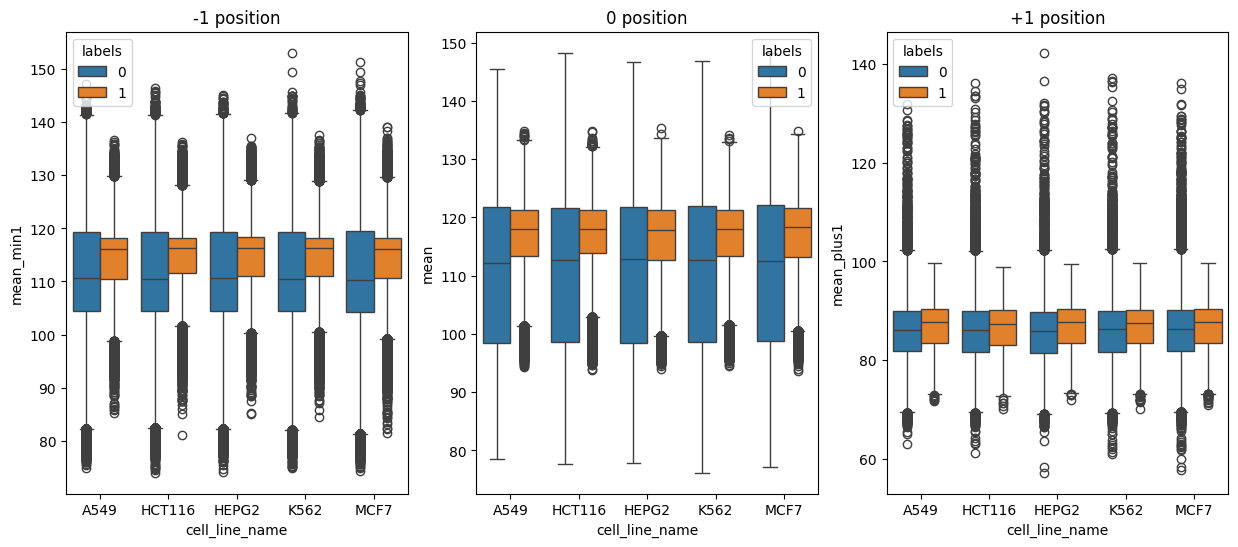

In [33]:
fig, ax = plt.subplots(1, 3, figsize=(15, 6))
barplot = sns.boxplot(x = 'cell_line_name', y = 'mean_min1', data = combined_df, hue = 'labels', ax = ax[0])
ax[0].set_title("-1 position")
new_labels = ['Unmodified', 'Modified']  
handles, _ = barplot.get_legend_handles_labels()
plt.legend(title='Labels', loc='lower left',  labels = new_labels, handles = handles, bbox_to_anchor=(0.5, -0.3), ncol=2)

sns.boxplot(x = 'cell_line_name', y = 'mean', data = combined_df, hue = 'labels', ax = ax[1])
ax[1].set_title("0 position")

sns.boxplot(x = 'cell_line_name', y = 'mean_plus1', data = combined_df, hue = 'labels', ax = ax[2])
ax[2].set_title("+1 position")

plt.show()

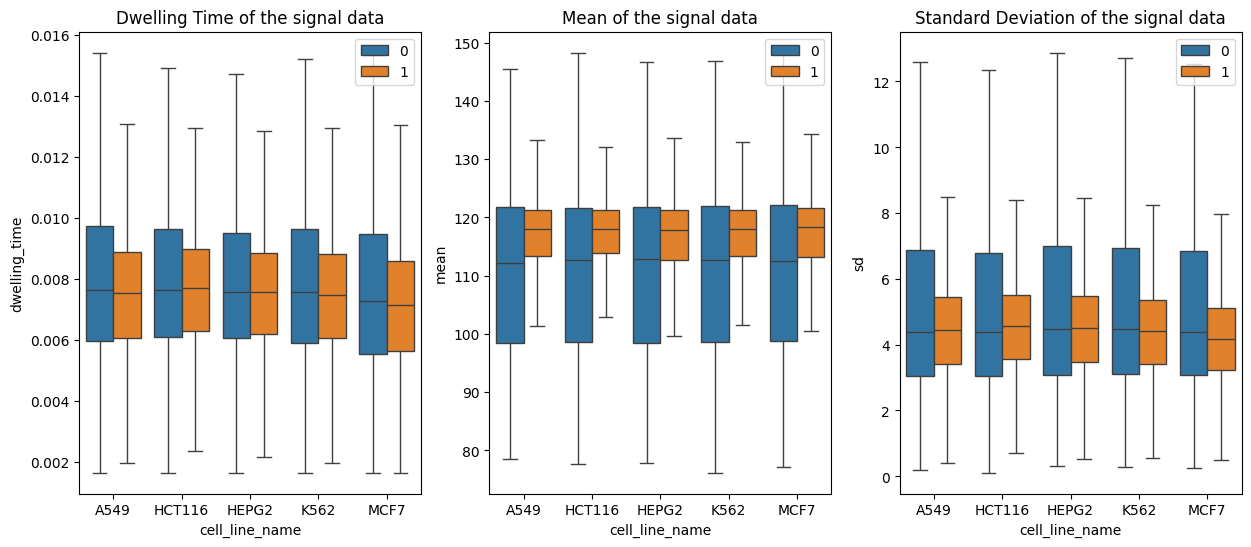

In [39]:
fig, ax = plt.subplots(1, 3, figsize=(15, 6))
sns.boxplot(x = 'cell_line_name', y = 'dwelling_time', data = combined_df, hue = 'labels', showfliers = False, ax = ax[0])
ax[0].legend(loc = 'upper right')
ax[0].set_title("Dwelling Time of the signal data")

sns.boxplot(x = 'cell_line_name', y = 'mean', hue = 'labels', showfliers = False, data = combined_df, ax = ax[1])
ax[1].legend(loc = 'upper right')
ax[1].set_title("Mean of the signal data")

sns.boxplot(x = 'cell_line_name', y = 'sd', data = combined_df, hue = 'labels', showfliers = False, ax = ax[2])
ax[2].legend(loc = 'upper right')
ax[2].set_title("Standard Deviation of the signal data")

plt.show()

Text(0.5, 1.0, '+1 position')

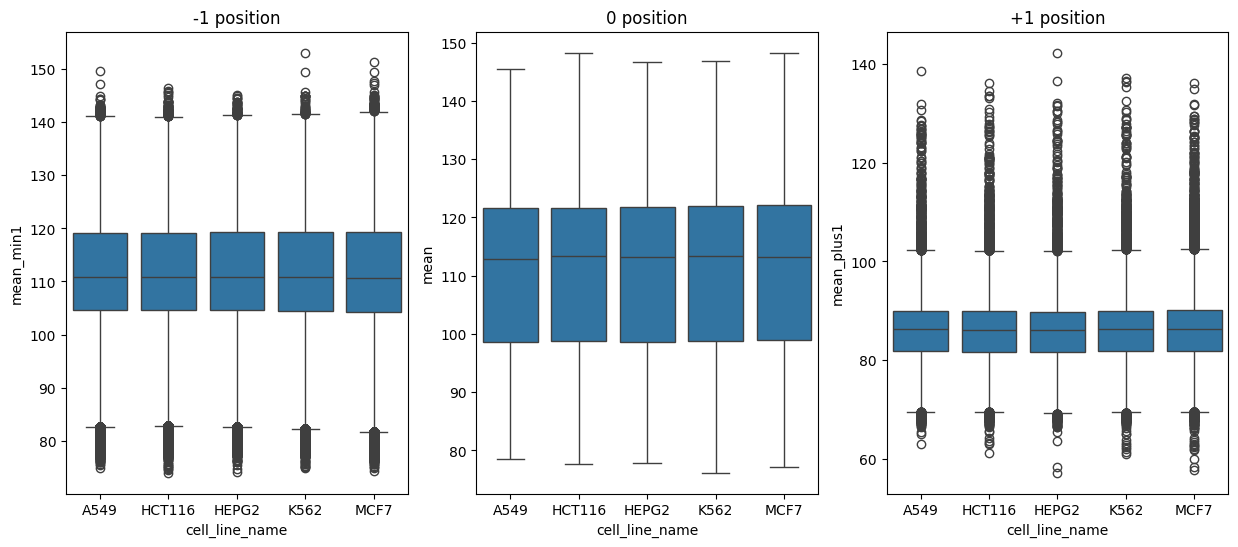

In [47]:
fig, ax = plt.subplots(1, 3, figsize=(15, 6))
sns.boxplot(x = 'cell_line_name', y = 'mean_min1', data = combined_df, ax = ax[0])
ax[0].set_title("-1 position")

sns.boxplot(x = 'cell_line_name', y = 'mean', data = combined_df, ax = ax[1])
ax[1].set_title("0 position")

sns.boxplot(x = 'cell_line_name', y = 'mean_plus1', data = combined_df, ax = ax[2])
ax[2].set_title("+1 position")

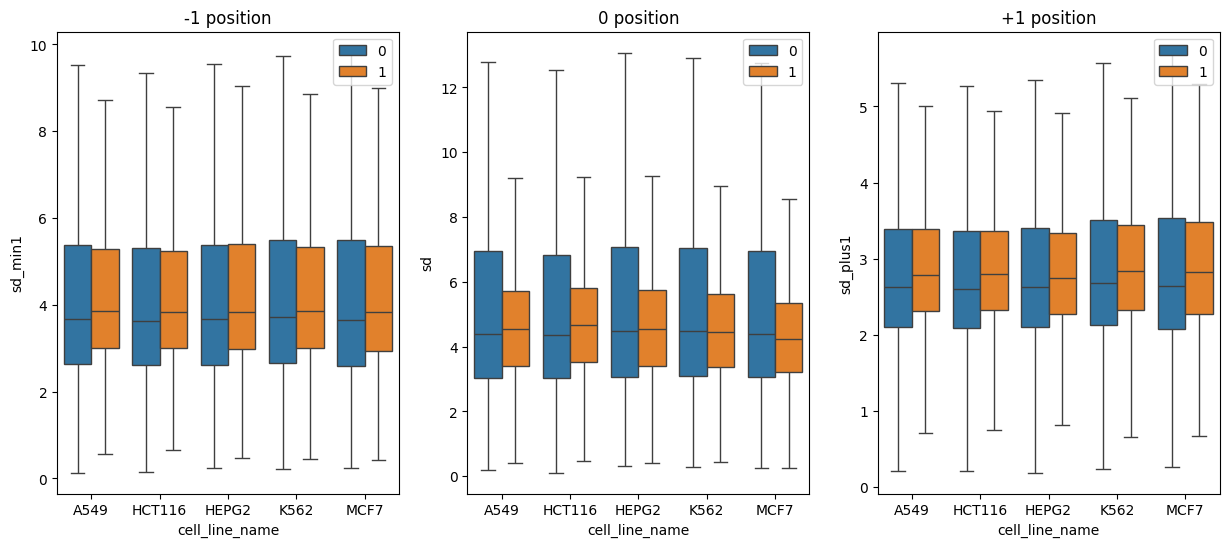

In [46]:
fig, ax = plt.subplots(1, 3, figsize=(15, 6))
sns.boxplot(x = 'cell_line_name', y = 'sd_min1', data = combined_df, hue = 'labels', showfliers = False, ax = ax[0])
ax[0].legend(loc = 'upper right')
ax[0].set_title("-1 position")

sns.boxplot(x = 'cell_line_name', y = 'sd', data = combined_df, hue = 'labels', showfliers = False, ax = ax[1])
ax[1].legend(loc = 'upper right')
ax[1].set_title("0 position")

sns.boxplot(x = 'cell_line_name', y = 'sd_plus1', data = combined_df, hue = 'labels', showfliers = False, ax = ax[2])
ax[2].legend(loc = 'upper right')
ax[2].set_title("+1 position")

plt.show()

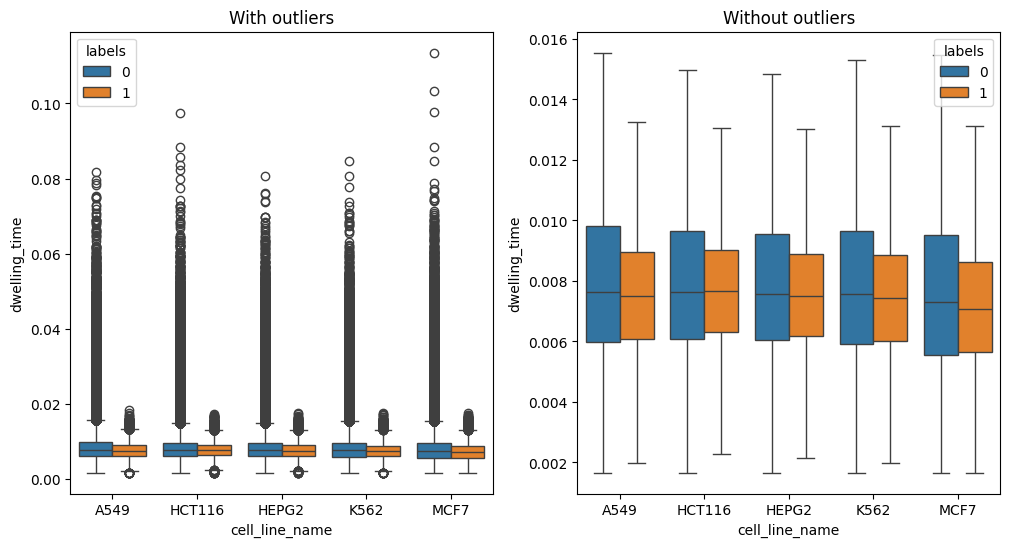

In [33]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
sns.boxplot(x = 'cell_line_name', y = 'dwelling_time', data = combined_df, hue = 'labels', ax = ax[0])
ax[0].set_title("With outliers")
sns.boxplot(x = 'cell_line_name', y = 'dwelling_time', data = combined_df, hue = 'labels', showfliers = False, ax = ax[1])
ax[1].set_title("Without outliers")
plt.show()

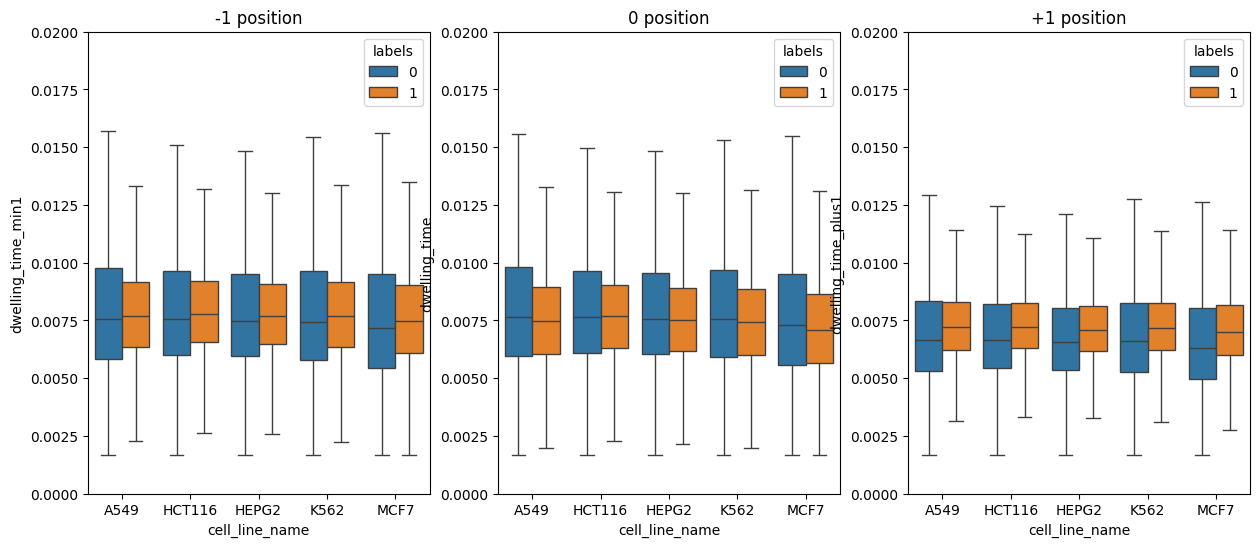

In [40]:
fig, ax = plt.subplots(1, 3, figsize=(15, 6))
sns.boxplot(x = 'cell_line_name', y = 'dwelling_time_min1', data = combined_df, hue = 'labels', showfliers = False, ax = ax[0])
ax[0].set_title("-1 position")
ax[0].set_ylim(0, 0.020)

sns.boxplot(x = 'cell_line_name', y = 'dwelling_time', data = combined_df, hue = 'labels', showfliers = False, ax = ax[1])
ax[1].set_title("0 position")
ax[1].set_ylim(0, 0.020)

sns.boxplot(x = 'cell_line_name', y = 'dwelling_time_plus1', data = combined_df, hue = 'labels', showfliers = False, ax = ax[2])
ax[2].set_title("+1 position")
ax[2].set_ylim(0, 0.020)
plt.show()

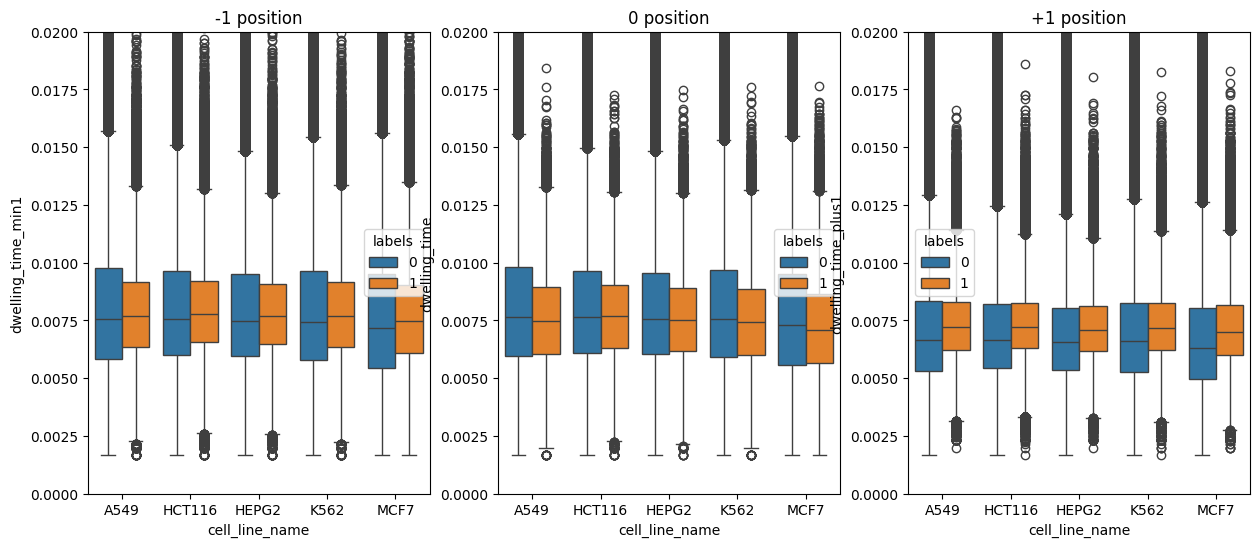

In [41]:
fig, ax = plt.subplots(1, 3, figsize=(15, 6))
sns.boxplot(x = 'cell_line_name', y = 'dwelling_time_min1', data = combined_df, hue = 'labels', ax = ax[0])
ax[0].set_title("-1 position")
ax[0].set_ylim(0, 0.020)

sns.boxplot(x = 'cell_line_name', y = 'dwelling_time', data = combined_df, hue = 'labels', ax = ax[1])
ax[1].set_title("0 position")
ax[1].set_ylim(0, 0.020)

sns.boxplot(x = 'cell_line_name', y = 'dwelling_time_plus1', data = combined_df, hue = 'labels', ax = ax[2])
ax[2].set_title("+1 position")
ax[2].set_ylim(0, 0.020)
plt.show()